# Training a causal Normalizing Flow

If you want to run the NB in colab.
```{python}
%pip install git+https://github.com/oduerr/cflow.git
```

In [5]:
### Definistion of the parameters
M = 30
N_train = 50000
EPOCHS = 100    
dpg_name = "VACA1"
hidden_features = (2,2)
# filename like filename = paste0(dpg_name, "_M", M, "_N",N_train, "_E", Epochs, "_", paste0(hidden_features, collapse = "_"), ".h5")
fn = f"{dpg_name}_M{M}_N{N_train}_E{EPOCHS}_{'_'.join(map(str, hidden_features))}.h5"
print(fn) #VACA1_M30_N50000_E100_2_2.h5

VACA1_M30_N50000_E100_2_2.h5


#### Definition of DGP (including the causal structure)

=== Using the DGP of the VACA1 paper in the linear Fashion (Tables 5/6)


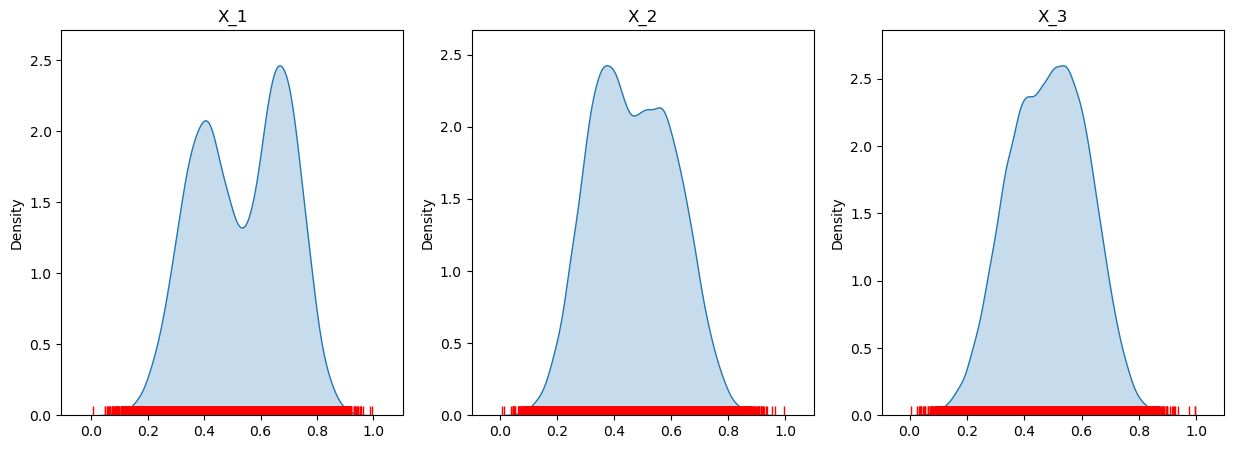

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential, Input
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from cflow.masked_linear import create_masks_np, LinearMasked, create_theta_tilde_maf, dag_loss
from cflow.utils import scale_df

######### DGP #########
def dgp(n_obs):
    print("=== Using the DGP of the VACA1 paper in the linear Fashion (Tables 5/6)")
    flip = np.random.choice([0, 1], n_obs)
    X_1 = flip * np.random.normal(-2, np.sqrt(1.5), n_obs) + (1 - flip) * np.random.normal(1.5, 1, n_obs)
    X_2 = -X_1 + np.random.normal(size=n_obs)
    X_3 = X_1 + 0.25 * X_2 + np.random.normal(size=n_obs)

    dat_s = np.column_stack((X_1, X_2, X_3))
    dat_tf = tf.constant(dat_s, dtype=tf.float32)

    scaled = scale_df(dat_tf) * 0.99 + 0.005

    A = np.array([[0, 1, 1], [0, 0, 1], [0, 0, 0]])
    return {'df_orig': dat_tf, 'df_scaled': scaled, 'A': A}

# Generate training data
train = dgp(N_train)
# Give summary statistics of df_scaled
import seaborn as sns

# Plot the KDEs of the training data
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    sns.kdeplot(train['df_scaled'][:, i], ax=axs[i], fill=True)
    sns.rugplot(train['df_scaled'][:, i], ax=axs[i], color='r')
    axs[i].set_title(f"X_{i+1}")
plt.show()

### Definition of the model

In [7]:
# Transpose the adjacency matrix
adjacency = np.transpose(train['A']) == 1 #Needs to be a boolean matrix
# Define layer sizes
layer_sizes = (adjacency.shape[1], *hidden_features, adjacency.shape[0])
print(f"A: {adjacency}, Layer sizes: {layer_sizes}")
masks = create_masks_np(adjacency = adjacency, hidden_features=hidden_features)
param_model = create_theta_tilde_maf(adjacency=adjacency, order=M+1, layer_sizes=layer_sizes, masks=masks)
from keras.utils import plot_model
print(f"Output of untrained model {param_model(tf.constant(train['df_scaled'], dtype=tf.float32)).shape}")  
if (M<4):
    plot_model(param_model, to_file='model_graph.png', show_shapes=True)

A: [[False False False]
 [ True False False]
 [ True  True False]], Layer sizes: (3, 2, 2, 3)
Output of untrained model (50000, 3, 31)


In [8]:
optimizer = Adam()
param_model.compile(optimizer=optimizer, loss=dag_loss)

In [9]:
### Temoorary code to check the layer names
layer_names = [layer.name for layer in param_model.layers]
unique_layer_names = set(layer_names)
if len(layer_names) != len(unique_layer_names):
    print("There are duplicate layer names.")
else:
    print("No duplicate layer names.")
layer_names[0:5]

No duplicate layer names.


['input_1', 'LM_o1_l1', 'LM_o2_l1', 'LM_o3_l1', 'LM_o4_l1']

#### Fitting the model

In [10]:
# Fit the model if the file  fn does not exist
import os
fn_model = fn.replace(".h5", ".keras")
if not os.path.exists(fn_model):
    history = None
    history = param_model.fit(x=tf.constant(train['df_scaled'], dtype=tf.float32), 
                            y=tf.constant(train['df_scaled'], dtype=tf.float32), 
                            epochs=EPOCHS, 
                            verbose=True)
    param_model.save_weights(fn, save_format='h5')
    param_model.save() # Save the model
else:
    print("Loading model from file")
    # Load the model from the file (weights would be also OK)
    param_model = tf.keras.models.load_model(fn_model, 
        custom_objects={
            'LinearMasked': LinearMasked,
            'custom_loss': dag_loss
        })   

Loading model from file


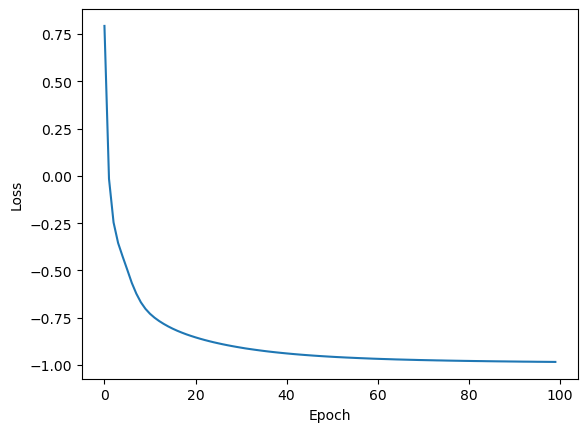

In [45]:
# Plot training history
if (history is not None):
    plt.plot(history.epoch, history.history['loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()